<a href="https://colab.research.google.com/github/inetolko2b-svg/shine_light_on_dyes/blob/main/HOMO_LUMO_for_polyenes_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Calculating HOMO-LUMO gaps for conjugated systems!**
In this section, we’re going to get some numerical estimates for the HOMO–LUMO gaps of conjugated systems. These numbers are mainly useful for comparing different molecules — they won’t be accurate enough to predict the exact colors of the molecules (for that, see …).

We’ll take things one step further by using some ready‑made functions that can solve quantum chemical equations for us. These tools will give us numerical values for the energies of the molecular orbitals in a given molecule. We won’t dive into where these equations come from or exactly how they’re solved — instead, we’ll focus on how to use them to get meaningful and useful information about our molecules.

Below is the first code snippet that we need to run to begin our calculations. To execute the code, simply click the **Run** button and wait. This step should only take a short time. We start by installing the required packages and importing the necessary definitions. Packages are collections of Python files that contain useful pieces of code. Installing and importing them allows us to use many predefined functions without having to write the code from scratch. Note! the packages are not installed on your local computer. Instead,
Google Colab runs on a remote virtual machine. When you install a package using you are installing it on that virtual machine, not on your own computer. The installed packages will only exist for the duration of your session. Once the session ends (e.g., due to inactivity or manual reset), you'll need to reinstall them the next time you open the notebook. Once the code is executed the resutl will appear in the output window.

In [ ]:
! pip install rdkit
! pip install pyscf
! pip install geometric

# import these definitions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# import the package
from pyscf import gto, scf, dft, tddft
from pyscf.geomopt.geometric_solver import optimize
import scipy.constants as cst
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geometric: filename=geometric-1.1-py3-none-any.whl size=402087 sha256=ae52551fdc6371a4842a6764ac92578c2a24b5f92d91c93be6d315c997a232c8
  Stored in directory: /root/.cache/pip/wheels/c5/77/0c/96a54539fe0560749fdbe283f92582d09bddb212856407a4cb
Successfully built geometric


The code provided in this example is for 1,3,5-hexatriene. You will need to slightly adjust it for your specific molecule. We will explain exactly how to do this below.

First we need to generate the desired molecule. The easiest way to do this is by using SMILES (Simplified Molecular Input Line Entry System). Every molecule can be represented as a string of symbols containing information about the types of atoms in the molecule and their connectivity. However, SMILES does not contain information about the three‑dimensional geometry of the molecule.

For common molecules, it is usually easy to find their SMILES representation online. For example, you can find the SMILES of a desired molecule in PubChem (https://pubchem.ncbi.nlm.nih.gov/) by searching for it by name or drawing its structure.

In the code below, we convert the SMILES format into an XYZ file, which contains the 3D coordinates of each atom. An XYZ file is simply a table listing the x, y, and z coordinates for each atom in the molecule. This file will appear under the Files icon on the left in Google Colab and can be downloaded and opened in various specialized molecular visualization programs — for example, in Avogadro, a free, open‑source molecular editor available at https://avogadro.cc/downloads/.

The code below reads SMILES and convert use this information to build a random 3D structure, where the angles and bond lengths are random and not optimized, every time you run the cell you will generate a new conformation.

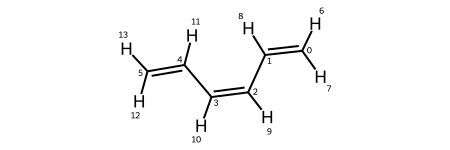

In [ ]:
# import these definitions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# generate the moleucle
smiles = r"C=CC=CC=C" # insert smiles for your molecule
mol = Chem.MolFromSmiles(smiles)
#Add hydrogen atoms to the molecule
mol = Chem.AddHs(mol)
#Generate a random 3D configuration
Chem.AllChem.EmbedMolecule(mol)
#Safe the molecule in XYZ file under desired name
Chem.MolToXYZFile(mol, "1,3,5-HEXATRIENE.xyz")
mol

The next cell is not necessary for our main purpose but can be interesting for those who want to learn how to perform simple manipulations on the molecule we have generated. For example, we can change dihedral angles. In the cell below, you can see how to do this and observe how it changes the structure of the molecule.

We will use the function
Chem.rdMolTransforms.SetDihedralDeg(mol.GetConformer(0), a, b, c, d, angle)
where you input the numbers of the atoms between which you want to set the dihedral angle, along with the desired angle in degrees. In the example below, we set the angle between atoms 1, 2, 3, and 4 to 180 degrees. You can try creating various structures by changing these values.For the atom numbers, refer to the image generated after running the previous cell.

It is important to understand that each of these structures will have a different energy. Generally, compounds with a dihedral angle around a double bond of about 180 degrees are more stable. You can experiment with this for your particular compound.

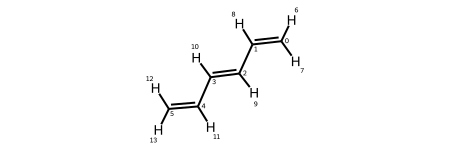

In [ ]:
#set dihedral angle between atoms 1,2,3,4 to 0
Chem.AllChem.SetDihedralDeg(mol.GetConformer(0),1,2,3,4,180)
#Safe the molecule in XYZ file
Chem.MolToXYZFile(mol, "1,3,5-HEXATRIENE.xyz")
mol


So now we have generated a molecule with a rather random structure (even though we have seen how we can change the angles). The structure is still not optimal; the exact bond angles and lengths are not perfect and do not correspond to the real molecule.

Now we will use this unoptimized structure to let Python perform calculations that adjust the angles and bond lengths between atoms to make the structure closer to the real one. We will omit the details of how this function works. Simply put, it changes the coordinates of the atoms, calculates the energy of the system, predicts how to adjust the coordinates to lower the energy, updates them, and then recalculates the energy. This process repeats until the energy changes become negligible.

As with all calculations, there is always a trade-off between time and accuracy. The more precise we want to be, the longer the calculation will take. Here, we choose a relatively fast method, which is good enough for our purpose — to observe differences in HOMO-LUMO gaps in conjugated systems — but it will not be accurate enough to predict real properties with high precision.

In [ ]:
from pyscf import gto, scf, dft, tddft

# create the pyscf molecule
mol = gto.Mole()
mol.atom="1,3,5-HEXATRIENE.xyz"# put the name of xyz file for your molecule
# set basis set
mol.basis = "sto-3g"
mol.build()

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run optimatization  calculations
mol_eq = optimize(mf)

#save the optimizaed molecule
mol_eq.tofile("opt_1,3,5-HEXATRIENE.xyz")#put a name of the file to save your optimized structure

geometric-optimize called with the following command line:
/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-a087d6d2-6775-4093-9370-ee4b8c8be8d9.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1


/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.507901  -0.352986   0.239323    0.000000  0.000000  0.000000
   C   0.497870   0.380491  -0.240705    0.000000  0.000000  0.000000
   H  -0.317622  -1.415163   0.361052    0.000000  0.000000  0.000000
   H  -1.472704   0.073120   0.499874    0.000000  0.000000  0.000000
   H   1.419826  -0.135383  -0.470431    0.000000  0.000000  0.000000
   H   0.380531   1.449921  -0.389113    0.000000  0.000000  0.000000
converged SCF energy = -77.619634712641
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0153705113    -0.0054996950     0.0063312116
1 C     0.0202192392     0.0069658956    -0.0082805784
2 H     0.0096198511     0.0102131141    -0.0051570720
3 H     0.0080091154     0.0011298571    -0.0029881881
4 H    -0.0153411794    -0.0044870208     0.0061365965
5 H    -0.0071370111    -0.0083225170     0.0039578458
--------------

Step    0 : Gradient = 1.612e-02/2.293e-02 (rms/max) Energy = -77.6196347126
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.52872e-01 3.58548e-01 5.85332e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.482906  -0.392429   0.237583    0.024995 -0.039443 -0.001740
   C   0.517082   0.356611  -0.243142    0.019212 -0.023880 -0.002437
   H  -0.464085  -1.473813   0.422400   -0.146463 -0.058650  0.061348
   H  -1.433878   0.093790   0.482668    0.038826  0.020670 -0.017206
   H   1.509558  -0.016491  -0.522686    0.089732  0.118892 -0.052255
   H   0.354244   1.432342  -0.376817   -0.026287 -0.017579  0.012296
converged SCF energy = -77.6213283262539
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0013848689    -0.0067486681     0.0016812605
1 C     0.0070999331     0.0045012892    -0.0032734261
2 H    -0.0062237666    -0.0001882853     0.0022007820
3 H     0.0024060741     0.0007866560    -0.0009763258
4 H     0.0007483090     0.0030592521    -0.0008023276
5 H    -0.0026460967    -0.0014091950

Step    1 : Displace = 1.001e-01/1.693e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 5.825e-03/9.021e-03 (rms/max) E (change) = -77.6213283263 (-1.694e-03) Quality = 0.352
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.55722e-01 3.78815e-01 6.09906e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.500369  -0.371342   0.239888   -0.017462  0.021087  0.002305
   C   0.501872   0.367571  -0.239735   -0.015210  0.010960  0.003407
   H  -0.400339  -1.454167   0.396668    0.063745  0.019646 -0.025731
   H  -1.473366   0.068865   0.500767   -0.039487 -0.024925  0.018099
   H   1.478898  -0.061277  -0.504025   -0.030660 -0.044786  0.018661
   H   0.393342   1.450322  -0.393544    0.039099  0.017980 -0.016727
converged SCF energy = -77.622403271069
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0012582010     0.0000937080     0.0004220945
1 C     0.0012978599    -0.0010272868    -0.0002705985
2 H     0.0005662492    -0.0011421036     0.0000067094
3 H    -0.0015276125     0.0009932762     0.0003577414
4 H     0.0017803420    -0.0001846615    -0.0005888284
5 H    -0.0008586512     0.0012672343 

Step    2 : Displace = 4.859e-02/7.142e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.610e-03/1.884e-03 (rms/max) E (change) = -77.6224032711 (-1.075e-03) Quality = 1.036
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.56614e-01 3.88870e-01 5.88497e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.496652  -0.371614   0.238601    0.003717 -0.000272 -0.001287
   C   0.497746   0.375297  -0.239622   -0.004126  0.007726  0.000113
   H  -0.397897  -1.452748   0.395487    0.002442  0.001418 -0.001181
   H  -1.469389   0.061581   0.500595    0.003977 -0.007284 -0.000172
   H   1.466332  -0.069130  -0.498184   -0.012565 -0.007853  0.005841
   H   0.399900   1.456576  -0.396853    0.006558  0.006254 -0.003309
converged SCF energy = -77.6223948096459
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C     0.0020428888    -0.0016716411    -0.0004147299
1 C    -0.0010591646     0.0026675734    -0.0001037209
2 H    -0.0007561852     0.0000090640     0.0002633061
3 H     0.0006750634     0.0000551348    -0.0002430323
4 H    -0.0010780673    -0.0012590976     0.0005964124
5 H     0.0001754478     0.0001988010

Step    3 : Displace = 9.284e-03/1.601e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.813e-03/2.872e-03 (rms/max) E (change) = -77.6223948096 (+8.461e-06) Quality = -0.166
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.74184e-01 4.66263e-01 5.93981e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.499402  -0.370428   0.239337   -0.002750  0.001186  0.000736
   C   0.499197   0.370787  -0.239318    0.001451 -0.004510  0.000304
   H  -0.398072  -1.451263   0.395263   -0.000175  0.001486 -0.000225
   H  -1.472017   0.063269   0.501190   -0.002628  0.001688  0.000595
   H   1.471412  -0.063981  -0.500842    0.005080  0.005149 -0.002657
   H   0.398923   1.451579  -0.395606   -0.000978 -0.004997  0.001247
converged SCF energy = -77.6224319381052
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0000268599    -0.0000399044     0.0000172126
1 C     0.0000029898     0.0001526212    -0.0000288330
2 H    -0.0000029058     0.0003322720    -0.0000560571
3 H     0.0003538349    -0.0001418359    -0.0000963734
4 H    -0.0003877672     0.0000872107     0.0001179983
5 H     0.0000607104    -0.0003903794

Step    4 : Displace = 4.678e-03/7.731e-03 (rms/max) Trust = 4.642e-03 (-) Grad = 3.227e-04/4.146e-04 (rms/max) E (change) = -77.6224319381 (-3.713e-05) Quality = 0.920
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.78100e-01 4.87597e-01 5.80351e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.499444  -0.370729   0.239368   -0.000042 -0.000301  0.000031
   C   0.499563   0.370589  -0.239375    0.000366 -0.000197 -0.000056
   H  -0.398766  -1.452200   0.395600   -0.000694 -0.000937  0.000337
   H  -1.472532   0.063727   0.501220   -0.000516  0.000458  0.000031
   H   1.472781  -0.063504  -0.501335    0.001368  0.000477 -0.000494
   H   0.398440   1.452080  -0.395456   -0.000483  0.000501  0.000150
converged SCF energy = -77.6224326625345
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C     0.0000024945    -0.0000506040     0.0000090426
1 C     0.0000212152     0.0000079131    -0.0000097456
2 H     0.0000036287    -0.0001413121     0.0000254305
3 H    -0.0001498247     0.0000839779     0.0000389227
4 H     0.0001562342    -0.0000688034    -0.0000437539
5 H    -0.0000337490     0.0001688339

Step    5 : Displace = 9.164e-04/1.512e-03 (rms/max) Trust = 6.565e-03 (+) Grad = 1.390e-04/1.762e-04 (rms/max) E (change) = -77.6224326625 (-7.244e-07) Quality = 0.565
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.78100e-01 4.87597e-01 5.80351e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 13.531 seconds


'6\nXYZ from PySCF\nC          -0.49944402       -0.37072942        0.23936801\nC           0.49956274        0.37058949       -0.23937471\nH          -0.39876605       -1.45219956        0.39559970\nH          -1.47253236        0.06372741        0.50122041\nH           1.47278052       -0.06350448       -0.50133543\nH           0.39843969        1.45207982       -0.39545591'

Now we will use the structure of the optimized molecule to generate molecular orbitals and finally calculate the HOMO–LUMO gap. Again, we will not go into details about how exactly these calculations are performed. What is important for us is that we will obtain an array of numbers corresponding to the energies of all molecular orbitals for our molecule, expressed in Hartree — one of the units of energy. We will later convert these energies to electronvolts (eV), a more common unit for molecular energies, by simply multiplying by 27.2114.


In [60]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="opt_1,3,5-HEXATRIENE.xyz" # put the file name for the optimized structure
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114




converged SCF energy = -230.521757022809
MO Energies (in Hartree):
[-10.00714691 -10.00616244 -10.00572864 -10.00497269  -9.98833159
  -9.9879716   -0.78105701  -0.73830056  -0.68247594  -0.57195449
  -0.52672787  -0.51441325  -0.45163659  -0.42379798  -0.38849563
  -0.35522386  -0.33487299  -0.32443327  -0.30429245  -0.2943965
  -0.23515705  -0.15491758   0.04337549   0.14240214   0.22261413
   0.34329011   0.40332085   0.41871422   0.42915275   0.43546436
   0.44370883   0.45777972   0.57389533   0.6174346    0.66759089
   0.69989384   0.73743927   0.80541257]


So, we have the whole array of molecular orbitals! But we learned that the highest occupied molecular orbital (HOMO) and the lowest unoccupied molecular orbital (LUMO) are the most important orbitals for predicting color, since the energy of light absorbed often corresponds to this gap (there are exceptions, but we will omit those for now). How do we know which is the HOMO and which is the LUMO?

Let’s recap a little:
Molecules consist of atoms. In our case, we look at molecules containing only carbon and hydrogen. Each atom consists of a nucleus and electrons. Each hydrogen atom has 1 electron (atomic number 1 in the periodic table), and each carbon atom has 6 electrons (atomic number 6). For bond formation, only the electrons matter, since they hold the atoms together.

All electrons reside in orbitals, each of which can hold up to 2 electrons. The first thing we need to know is the total number of electrons in our molecule. For molecules consisting only of carbon and hydrogen, the total number is 6 times the number of carbon atoms plus 1 times the number of hydrogen atoms. So, for 1,3,5-hexatriene, it is 6 × 6 + 1 × 8 = 44. Try calculating this for your molecule.

Next, we place the electrons in orbitals, two per orbital, starting from the lowest energy orbital. For 44 electrons, we fill 22 orbitals. The last filled orbital (the 22nd) is the HOMO, and the next one (the 23rd) is the LUMO.

Calculate this for your molecule, then run the cell below to see if you got it right.

In [61]:
print("number of electrons = ", nelec)
print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")


number of electrons =  44
HOMO energy: -0.154918 Ha
LUMO energy: 0.043375 Ha
Energy gap: 5.40 eV


You are all set! Now, just go ahead and test the molecules we discussed first (ethylene and 1,3-butadiene). Compare their HOMO-LUMO gaps and see if it aligns with what we have learned. Then you can start expanding the conjugated system more and more to see how it affects the HOMO-LUMO gap.

Be aware that longer molecules will take much more time to compute and might not even be possible to handle in this system.